## Figure 4

- Panel A: Coefficient Plot
- Panel B: Min/Max Image Montage (4 examples per top feature)

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(RColorBrewer))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”


In [2]:
figure_dir <- "../figures"
output_main_figure_4 <- file.path(
    figure_dir, "main_figure_4_feature_importance.png"
)
results_dir <- file.path(
    "../../2.evaluate_models/classify_genotypes/model_evaluation_data"
)

## Generate coefficient plot

In [3]:
# Load data
feat_import_file <- file.path(results_dir, "feature_importances.parquet")

feat_import_df <- arrow::read_parquet(feat_import_file)

dim(feat_import_df)
head(feat_import_df)

[1] 852   2

feature_names,feature_importances
<chr>,<dbl>
Nuclei_AreaShape_Zernike_7_1,-0.03704024
Nuclei_RadialDistribution_ZernikePhase_RFP_4_4,-0.05366707
Cells_RadialDistribution_ZernikePhase_CY5_6_4,-0.03551811
Nuclei_RadialDistribution_ZernikeMagnitude_GFP_7_3,-0.05796016
Cytoplasm_Correlation_RWC_DAPI_RFP,-0.14077001
Cytoplasm_Texture_InfoMeas1_DAPI_3_03_256,0.58009995


In [4]:
# Split out components of feature name for visualization
feat_import_df <- feat_import_df %>%
    dplyr::arrange(desc(abs(feature_importances))) %>%
    tidyr::separate(
        feature_names,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2",
            "parameter3"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel) %>%
    dplyr::mutate(parameter1_cleaned = parameter1)

# Convert the feature_importances to the absolute value
feat_import_df <- feat_import_df %>%
  mutate(feature_importances = abs(feature_importances))

feat_import_df$channel_cleaned <- dplyr::recode(feat_import_df$channel_cleaned,
    "DAPI" = "Nucleus",
    "GFP" = "ER",
    "RFP" = "Actin",
    "CY5" = "Mito",
    .default = "other",
    .missing = "other"
)

feat_import_df$parameter1_cleaned <- dplyr::recode(feat_import_df$parameter1_cleaned,
    "DAPI" = "Nucleus",
    "GFP" = "ER",
    "RFP" = "Actin",
    "CY5" = "Mito",
    .default = "other",
    .missing = "other"
)


print(dim(feat_import_df))
head(feat_import_df, 3)

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 769 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 23, 24, ...].”


[1] 852  11


feature_names,compartment,feature_group,measurement,channel,parameter1,parameter2,parameter3,feature_importances,channel_cleaned,parameter1_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
Cytoplasm_RadialDistribution_FracAtD_RFP_4of4,Cytoplasm,RadialDistribution,FracAtD,RFP,4of4,NA,NA,1.946568,Actin,other
Cytoplasm_Intensity_MeanIntensityEdge_GFP,Cytoplasm,Intensity,MeanIntensityEdge,GFP,NA,NA,NA,1.895561,ER,other
Cells_Correlation_Correlation_DAPI_GFP,Cells,Correlation,Correlation,DAPI,GFP,NA,NA,1.804010,Nucleus,ER


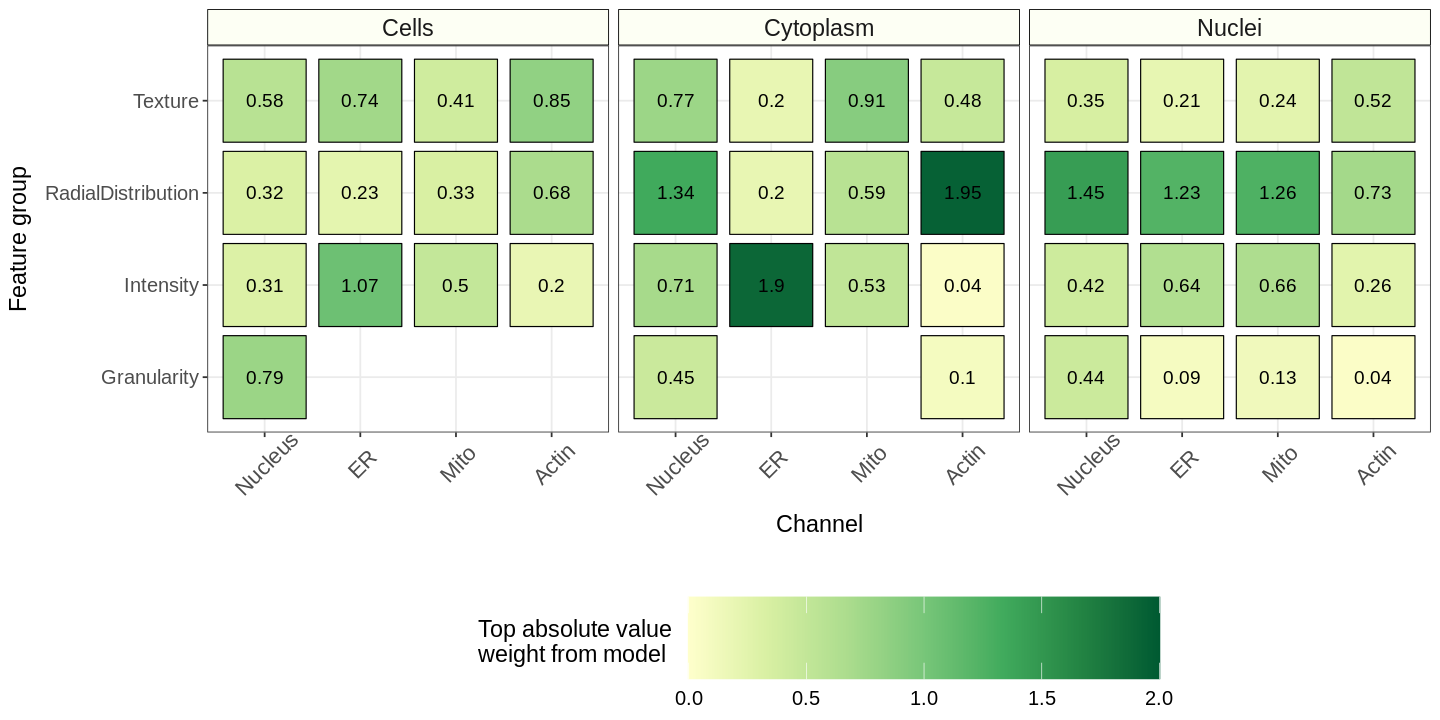

In [5]:
channels <- c(
    "Mito" = "Mito",
    "Nucleus" = "DNA",
    "ER" = "ER",
    "Actin" = "Actin",
    "other" = "other"
)

# Find top feature
top_feat_import_df <- feat_import_df %>%
    dplyr::filter(channel_cleaned %in% names(channels)) %>%
    dplyr::group_by(feature_group, channel_cleaned, compartment) %>%
    dplyr::slice_max(order_by = feature_importances, n = 1)

# Add rounded coefficient values to the data frame
top_feat_import_df <- top_feat_import_df %>%
    mutate(rounded_coeff = round(feature_importances, 2))

# Reorder the channel_cleaned factor levels
channel_order <- c("Nucleus", "ER", "Mito", "Actin", "other")
top_feat_import_df <- top_feat_import_df %>%
    mutate(channel_cleaned = factor(channel_cleaned, levels = channel_order))

# Process data for plotting
other_feature_group_df <- top_feat_import_df %>%
    dplyr::filter(!feature_group %in% c("AreaShape", "Correlation", "Neighbors"))

width <- 12
height <- 6
options(repr.plot.width = width, repr.plot.height = height)

# Create the plot
feature_importance_gg <- (
    ggplot(other_feature_group_df, aes(x = channel_cleaned, y = feature_group))
    + geom_point(aes(fill = feature_importances), pch = 22, size = 26)
    + geom_text(aes(label = rounded_coeff), size = 4)
    + facet_wrap("~compartment", ncol = 3)
    + theme_bw()
    + scale_fill_distiller(
        name = "Top absolute value\nweight from model",
        palette = "YlGn",
        direction = 1,
        limits = c(0, 2)
    )
    + xlab("Channel")
    + ylab("Feature group")
    + theme(
        axis.text = element_text(size = 12),
        axis.text.x = element_text(angle = 45, size = 13, vjust = 0.7, hjust = 0.5),
        axis.title = element_text(size = 14),
        strip.text = element_text(size = 14),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.position = "bottom", # Move legend to bottom
        legend.title = element_text(size = 14, margin = margin(b = 15)), # Increase space between title and gradient
        legend.text = element_text(size = 12),
        legend.key.height = unit(1.75, "cm"), # Increase height of legend key
        legend.key.width = unit(2, "cm"), # Optionally, increase width of legend key
        legend.margin = margin(t = 25),
    )
)

feature_importance_gg

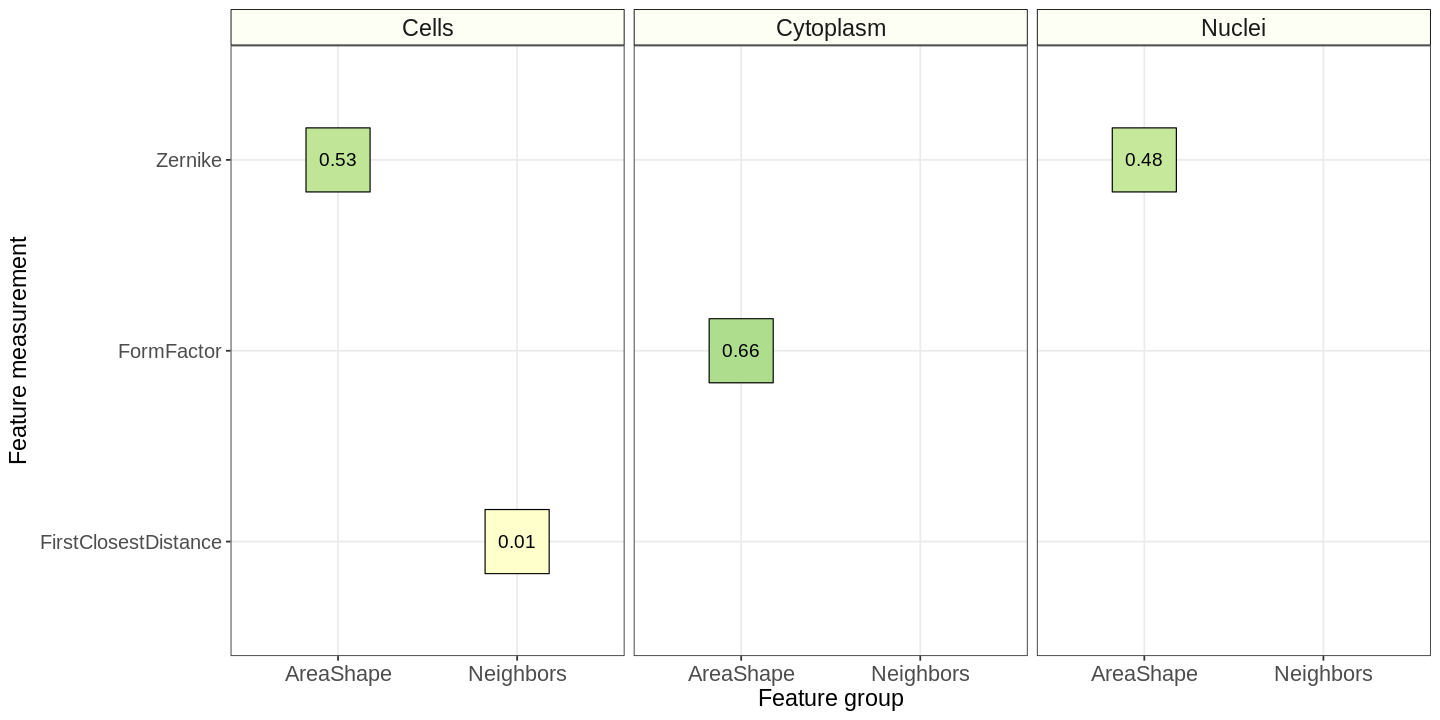

In [6]:
# Filter data to include AreaShape and Neighbors feature groups
area_shape_neighbors_df <- feat_import_df %>%
    dplyr::filter(feature_group %in% c("AreaShape", "Neighbors")) %>%
    dplyr::mutate(area_shape_indicator = paste(measurement, channel, parameter1, sep = "_"))

# Add rounded coefficient values to the data frame
area_shape_neighbors_df <- area_shape_neighbors_df %>%
    mutate(rounded_coeff = round(feature_importances, 2))

# Find top feature per measurement
top_area_shape_neighbors_df <- area_shape_neighbors_df %>%
    dplyr::filter(channel_cleaned %in% names(channels)) %>%
    dplyr::group_by(feature_group, channel_cleaned, compartment) %>%
    dplyr::slice_max(order_by = feature_importances, n = 1)

width <- 12
height <- 6
options(repr.plot.width = width, repr.plot.height = height)

# Create the plot
areashape_neighbors_importance_gg <- (
    ggplot(top_area_shape_neighbors_df, aes(x = feature_group, y = measurement))
    + geom_point(aes(fill = feature_importances), pch = 22, size = 20)
    + geom_text(aes(label = rounded_coeff), size = 4)
    + facet_wrap("~compartment", ncol = 3)
    + theme_bw()
    + scale_fill_distiller(
        name = "Top absolute\nvalue weight\nfrom model",
        palette = "YlGn",
        direction = 1,
        limits = c(0, 2)
    )
    + xlab("Feature group")
    + ylab("Feature measurement")
    + theme(
        axis.text = element_text(size = 12),
        axis.text.x = element_text(size = 13, vjust = 0.6, hjust = 0.5),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.position = "none"
    )
)

areashape_neighbors_importance_gg

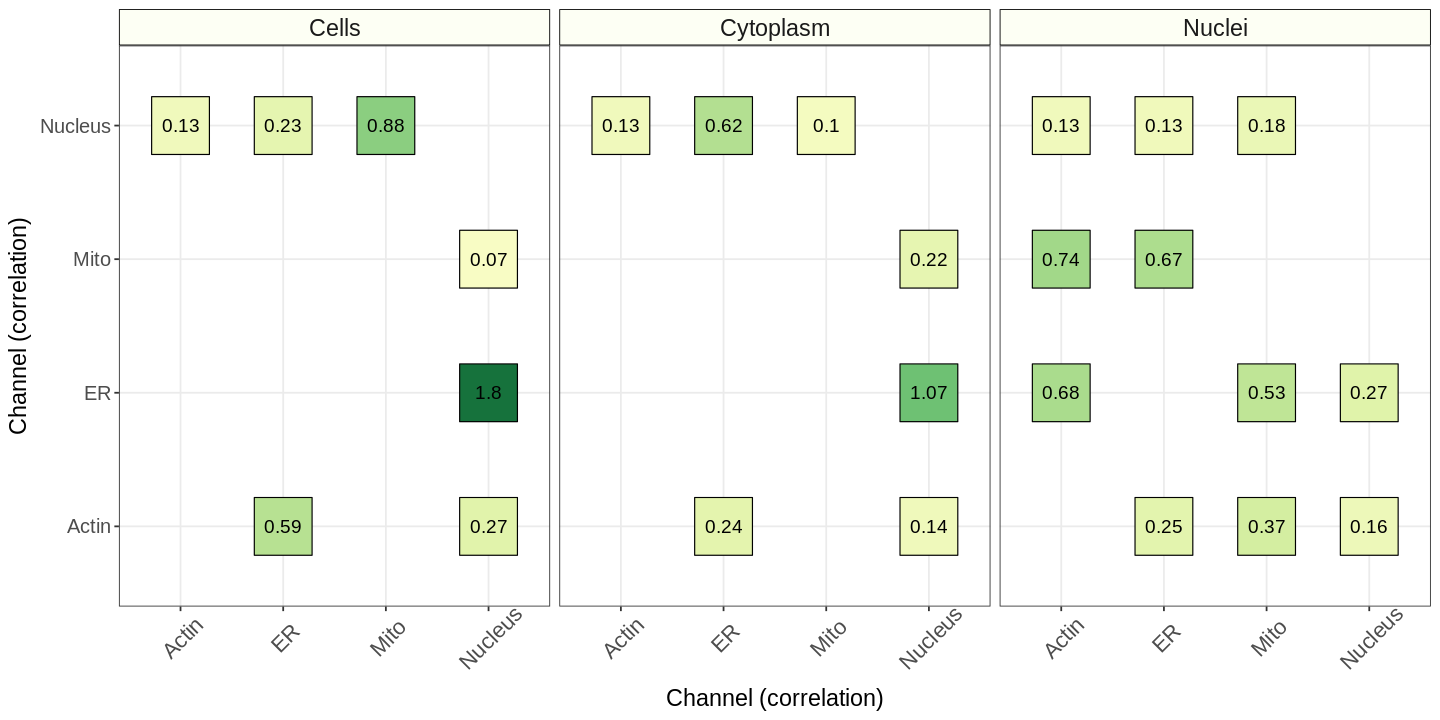

In [7]:
correlation_df <- feat_import_df %>% dplyr::filter(feature_group  == "Correlation")

# Add rounded coefficient values to the data frame
correlation_df <- correlation_df %>%
    mutate(rounded_coeff = round(feature_importances, 2))

# Find top feature per channel combo
top_correlation_df <- correlation_df %>%
    dplyr::filter(channel_cleaned %in% names(channels)) %>%
    dplyr::group_by(feature_group, channel_cleaned, compartment, channel, parameter1) %>%
    dplyr::slice_max(order_by = feature_importances, n = 1)

width <- 12
height <- 6
options(repr.plot.width = width, repr.plot.height = height)

# Create the plot
correlation_importance_gg <- (
    ggplot(top_correlation_df, aes(x = channel_cleaned, y = parameter1_cleaned))
    + geom_point(aes(fill = feature_importances), pch = 22, size = 18)
    + geom_text(aes(label = rounded_coeff), size = 4)
    + facet_wrap("~compartment", ncol = 3)
    + theme_bw()
    + scale_fill_distiller(
        name = "Top absolute\nvalue weight\nfrom model",
        palette = "YlGn",
        direction = 1,
        limits = c(0, 2)
    )
    + xlab("Channel (correlation)")
    + ylab("Channel (correlation)")
    + theme(
        axis.text = element_text(size = 12),
        axis.text.x = element_text(angle = 45, size = 13, vjust = 0.7, hjust = 0.5),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.position = "none"
    )
)

correlation_importance_gg

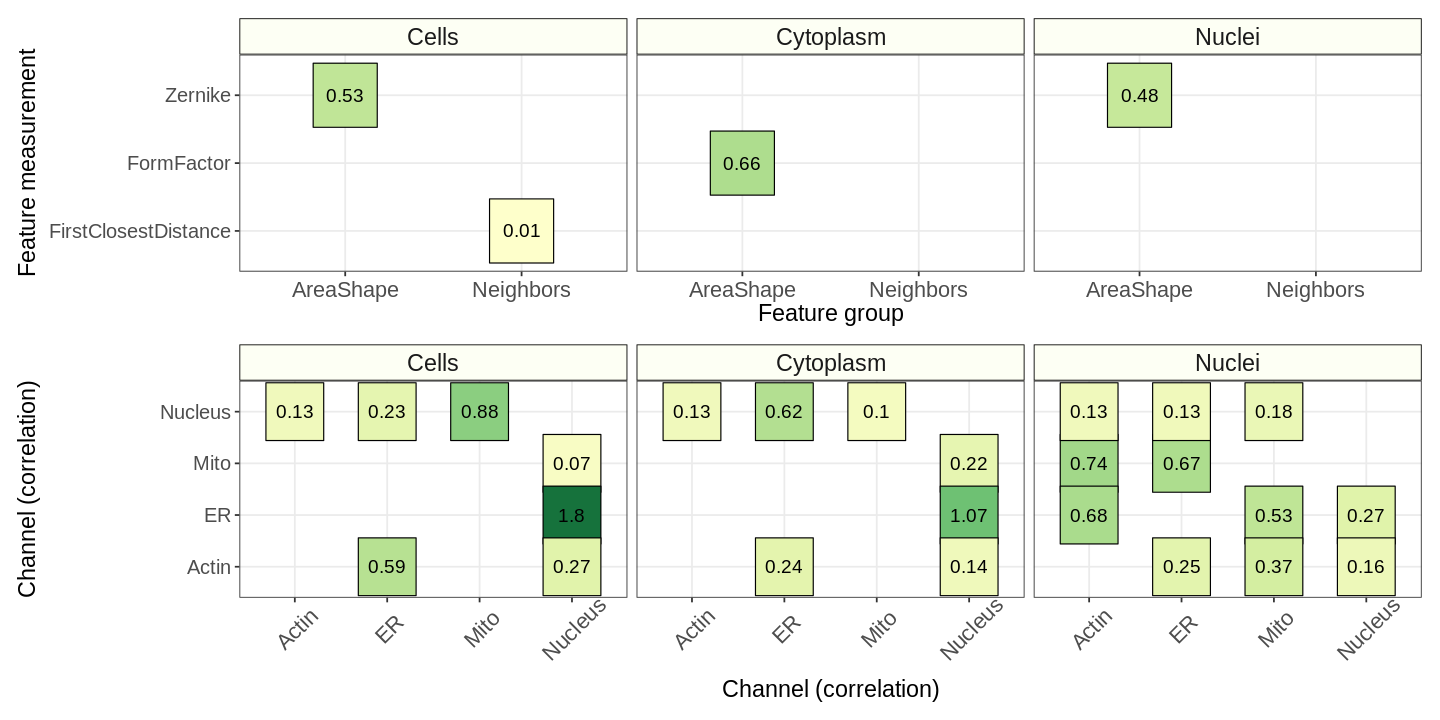

In [8]:
left_plot <- (
    areashape_neighbors_importance_gg /
    correlation_importance_gg
) + plot_layout(heights = c(1,1))

# ggsave("./coefficient_plot.png", align_plot, height=8, width=16, dpi=500)

left_plot

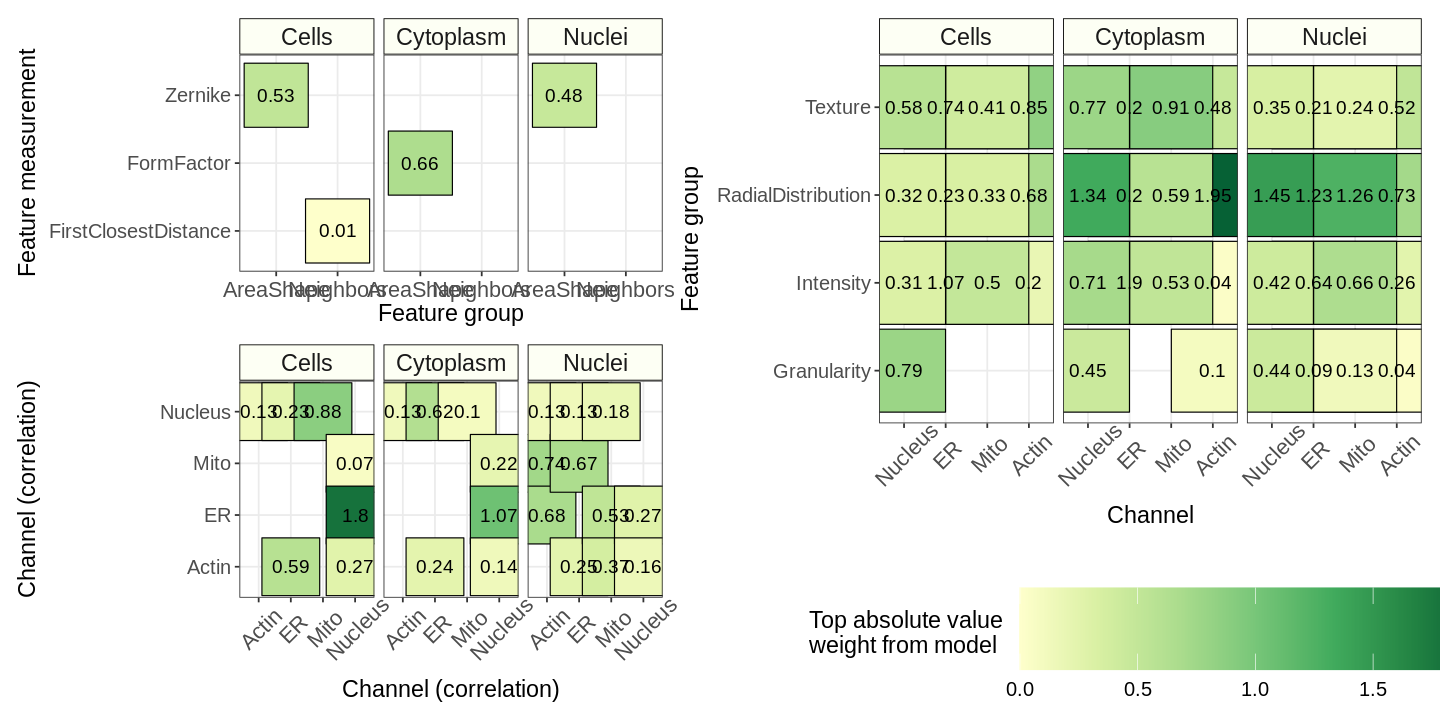

In [9]:
coefficient_plot <- (
    left_plot |
    free(feature_importance_gg)
) + plot_layout(widths = c(2,3.5))

ggsave("./coefficient_plot.png", coefficient_plot, width=21.5, height=7, dpi=500)

coefficient_plot

## Load in top Null and WT feature image montages

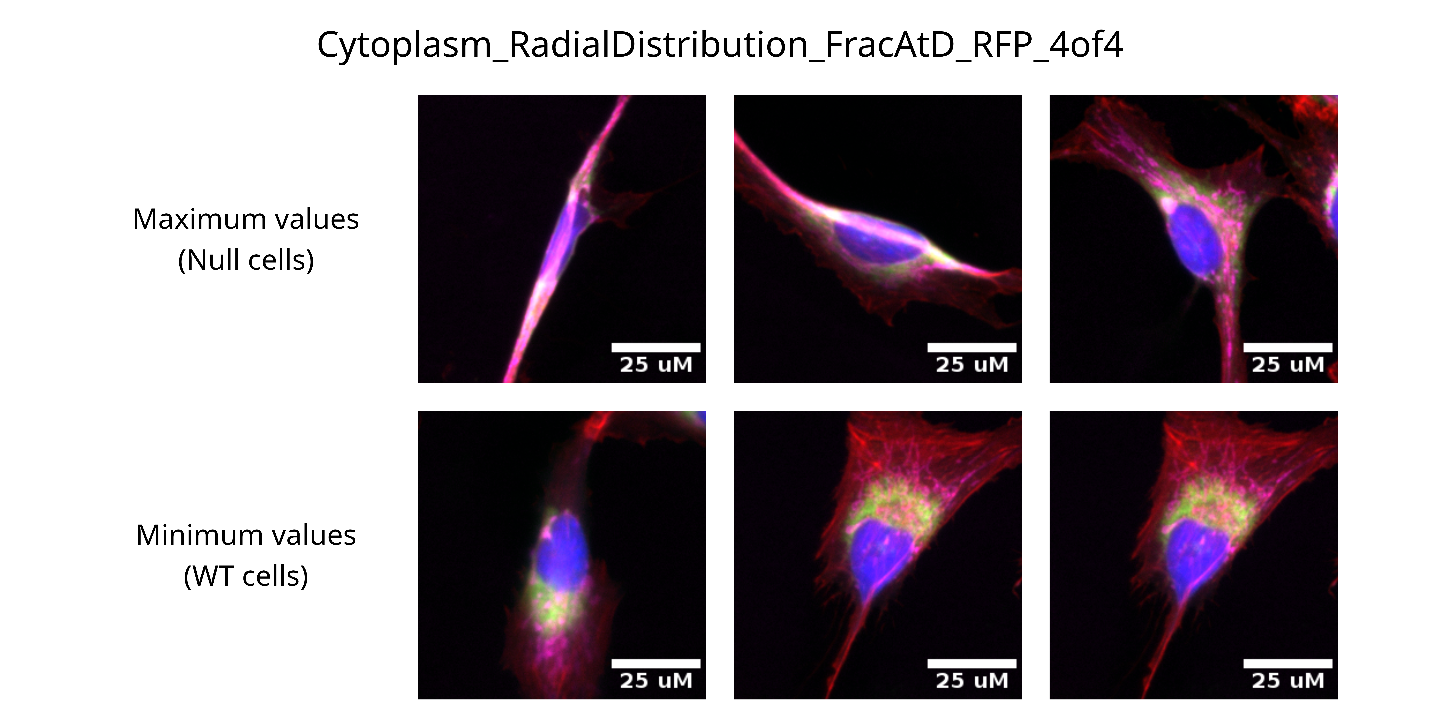

In [10]:
top_Null_path = file.path("./top_Null_feature_montage.png")
top_Null_img = png::readPNG(top_Null_path)

# Get the dimensions of the image
img_height <- nrow(top_Null_img)
img_width <- ncol(top_Null_img)

# Calculate the aspect ratio
aspect_ratio <- img_height / img_width

# Plot the image montage to a ggplot object
top_Null_montage <- ggplot() +
  annotation_custom(
    rasterGrob(top_Null_img, interpolate = TRUE),
    xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf
  ) +
  theme_void() +
  coord_fixed(ratio = aspect_ratio, clip = "off") +
  theme(plot.margin = margin(0, 0, 0, 0, "cm"))  # Adjust margins as needed

top_Null_montage

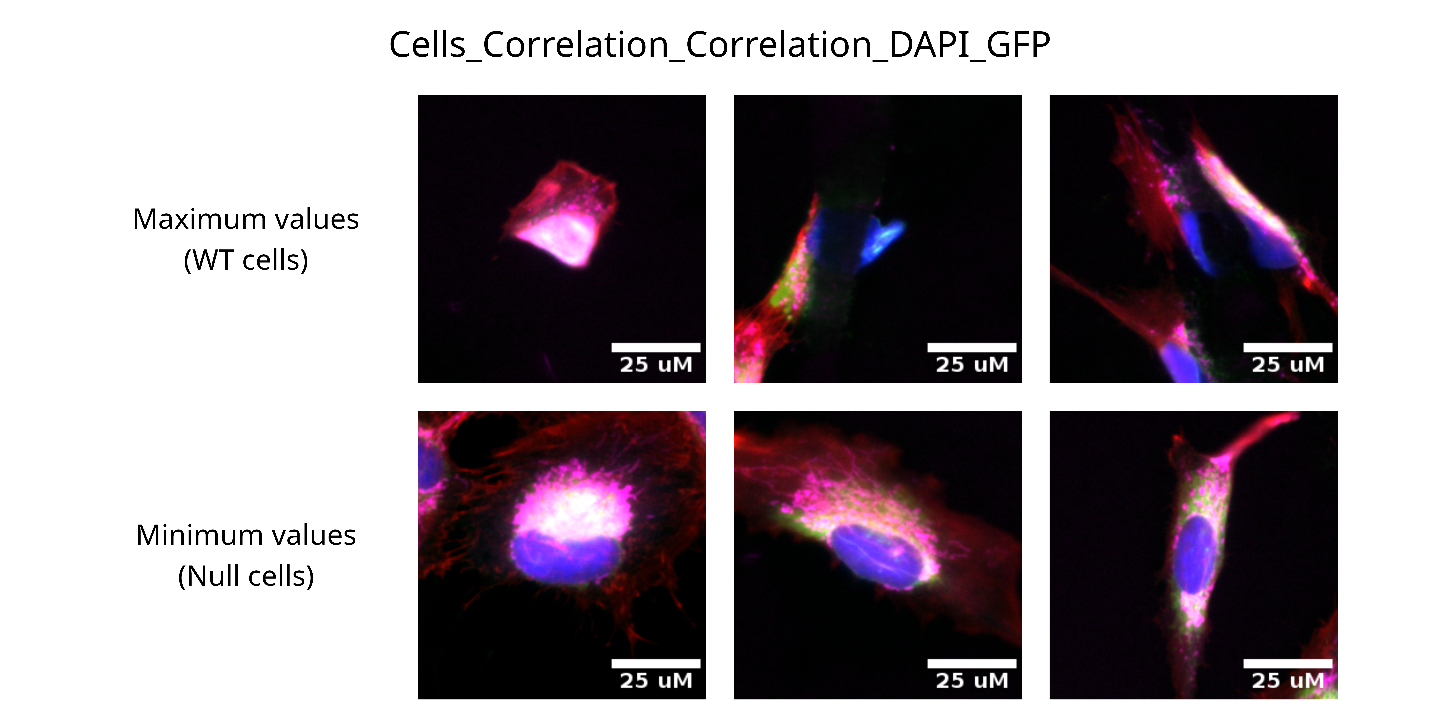

In [11]:
top_WT_path = file.path("./top_WT_feature_montage.png")
top_WT_img = png::readPNG(top_WT_path)

# Get the dimensions of the image
img_height <- nrow(top_WT_img)
img_width <- ncol(top_WT_img)

# Calculate the aspect ratio
aspect_ratio <- img_height / img_width

# Plot the image montage to a ggplot object
top_WT_montage <- ggplot() +
  annotation_custom(
    rasterGrob(top_WT_img, interpolate = TRUE),
    xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf
  ) +
  theme_void() +
  coord_fixed(ratio = aspect_ratio, clip = "off") +
  theme(plot.margin = margin(0, 0, 0, 0, "cm"))  # Adjust margins as needed

top_WT_montage

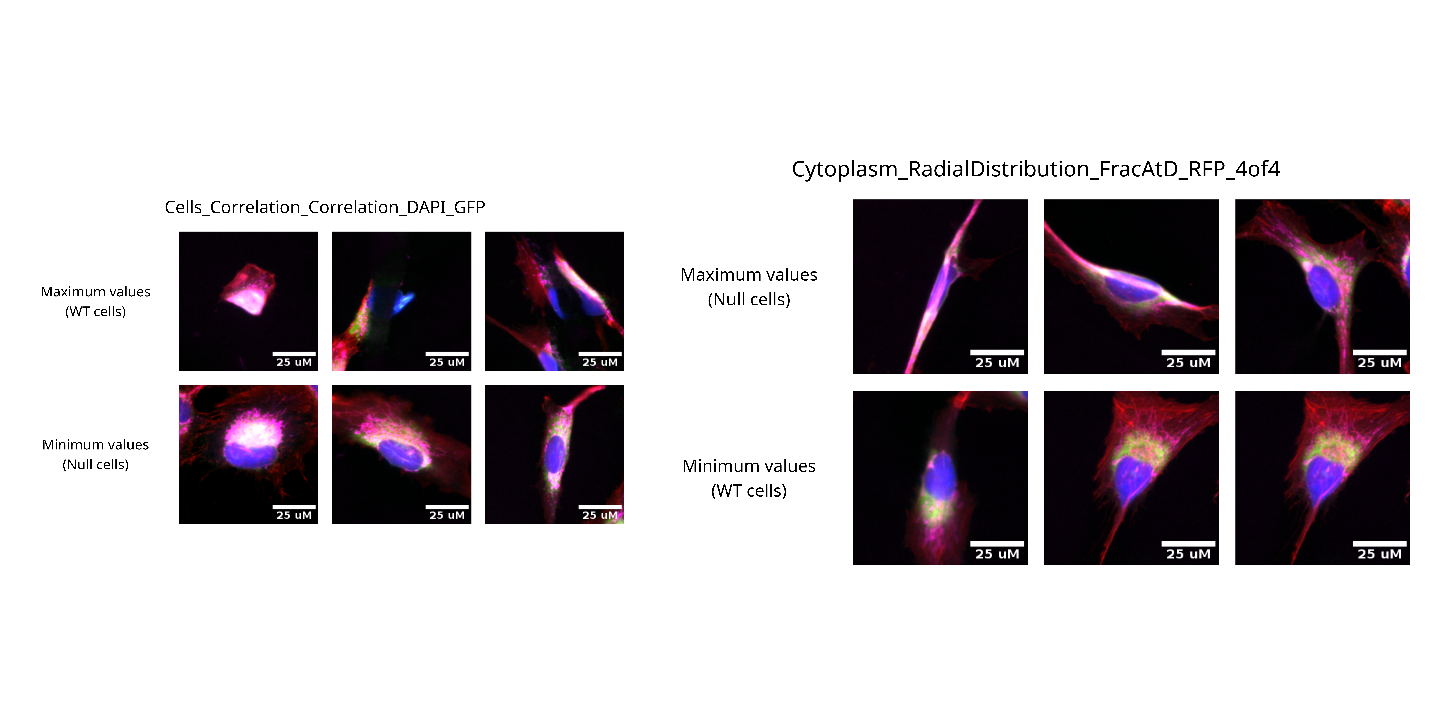

In [12]:
bottom_montage <- (
   free(top_WT_montage) | top_Null_montage
) + plot_layout(widths = c(1,1.25))

bottom_montage

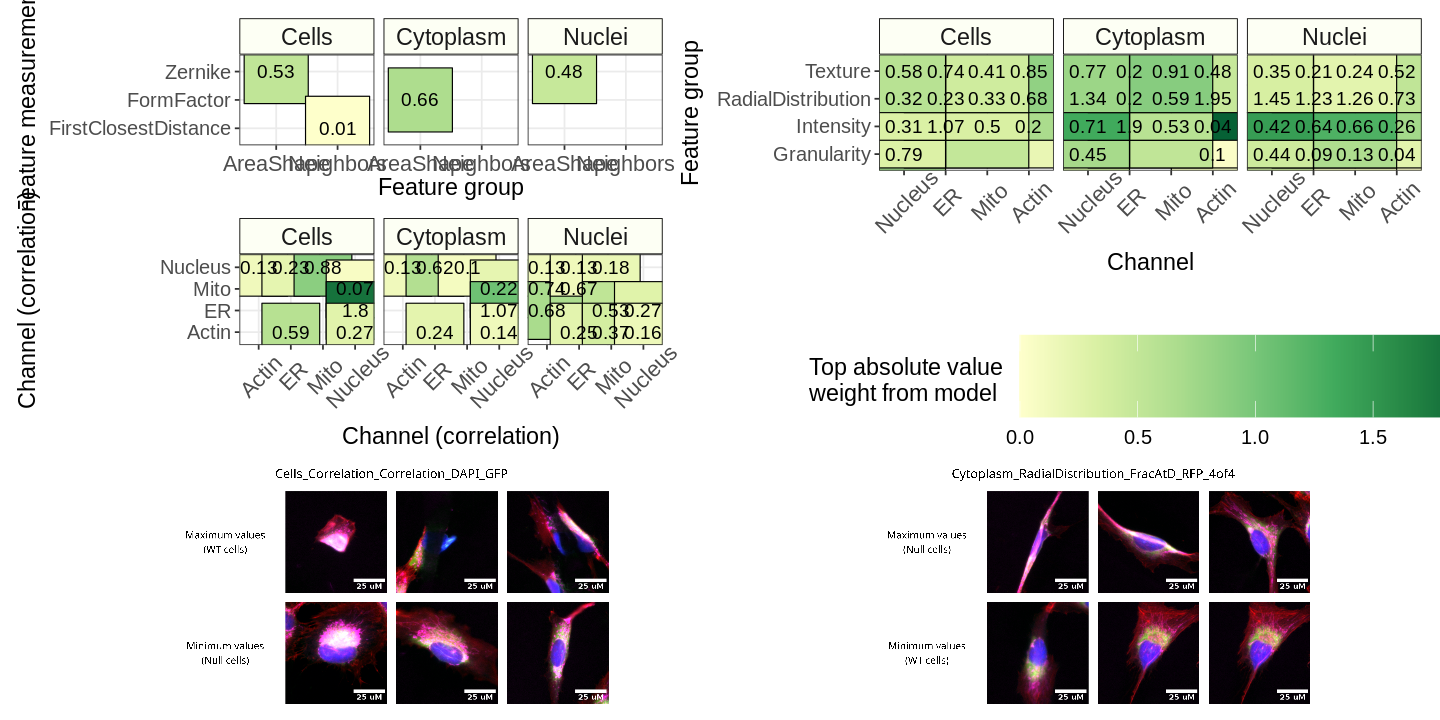

In [13]:
align_plot <- (
    coefficient_plot /
    bottom_montage
) + plot_layout(heights = c(1.15,1))

align_plot

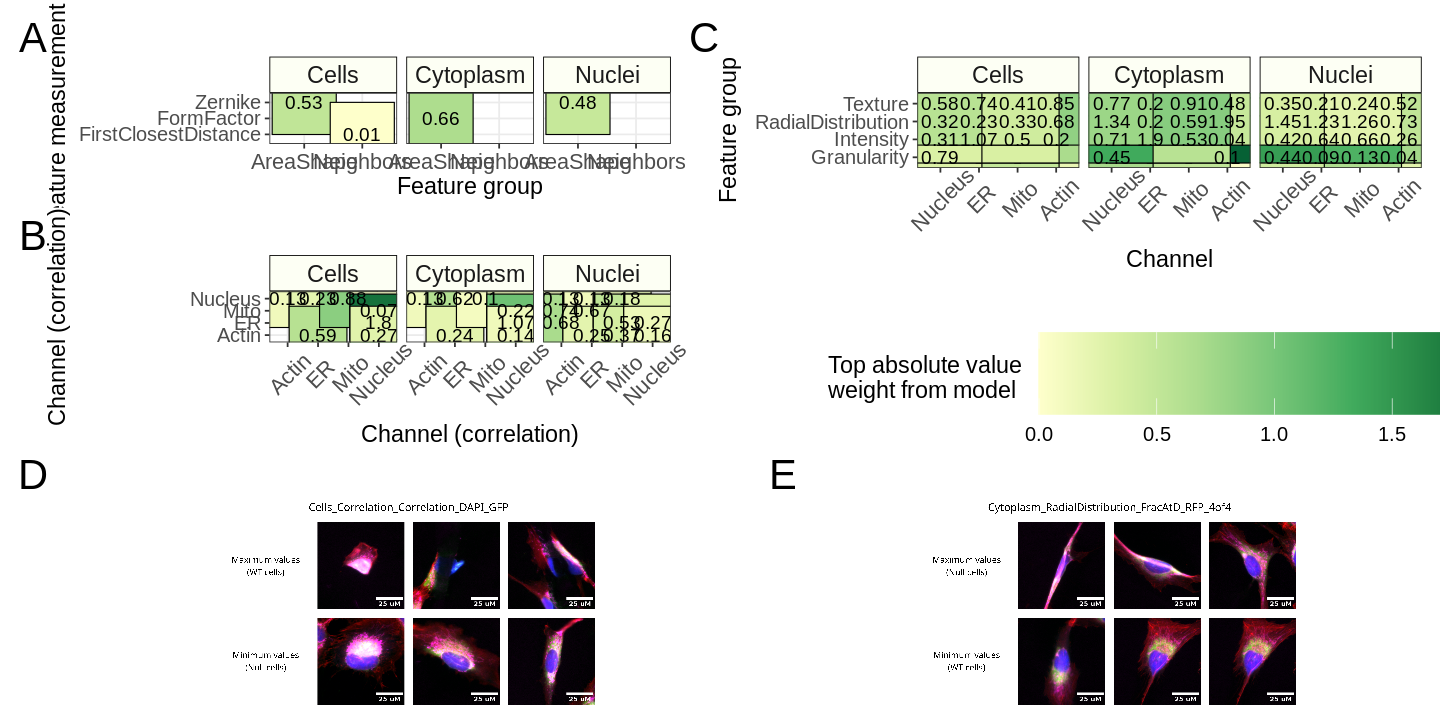

In [14]:
fig_4_gg <- (
  align_plot
) + plot_annotation(tag_levels = "A") & theme(plot.tag = element_text(size = 25))

# Save or display the plot
ggsave(output_main_figure_4, plot = fig_4_gg, dpi = 500, height = 13, width = 21.5)

fig_4_gg